# Simulación DCA

## Simulación parametrizable para ver posibles rendimientos de inversión a lo largo de los años con datos reales

Ticker: SPY
Período: 31/01/2018 → 17/10/2025
Aporte mensual: $100
Total invertido: $9.400
Valor final:     $17.527
Rent. total:     86.46%


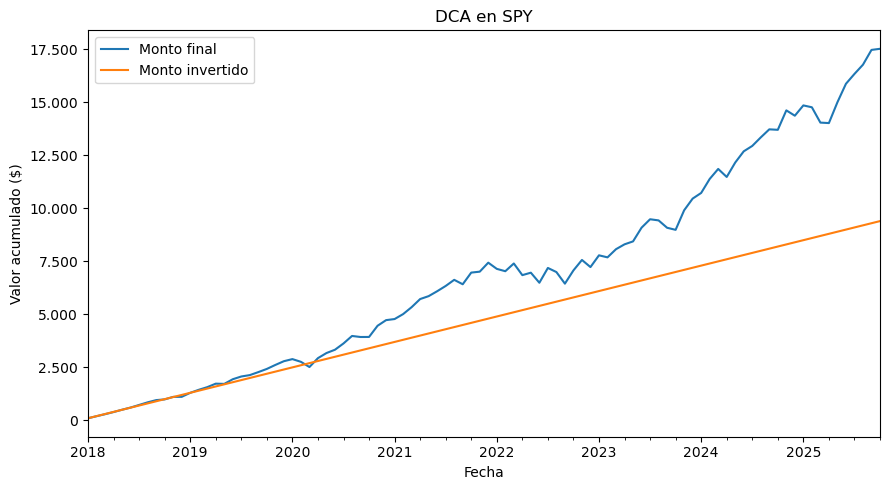

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Parámetros

ticker = "SPY"          
inicio = "2018-01-01"
aporte_mensual = 100

def ar_fmt_num(x):
    return f"{int(round(x)):,}".replace(",", ".") 

def ar_tick_fmt(x, pos):
    return ar_fmt_num(x)

# Descarga de precios ajustados

df = yf.download(ticker, start=inicio, auto_adjust=True, progress=False, interval="1d")
if df.empty:
    raise ValueError("No se obtuvieron datos. Revisá ticker, conexión o rango.")
df.index = pd.to_datetime(df.index)

# Obtengo columna de precio ajustadas (tiene en cuenta los dividenos)

if "Close" in df.columns:
    price = df[["Close"]]
elif "Adj Close" in df.columns:
    price = df[["Adj Close"]]
else:
    num_cols = df.select_dtypes("number").columns
    if len(num_cols) == 0:
        raise KeyError("No se encontró una columna de precio numérica.")
    price = df[[num_cols[0]]]

price = price.squeeze("columns") 
price.name = "price"
price = price.dropna()

# fin de mes

mensual_price = price.resample("ME").last().dropna()
mensual = pd.DataFrame({"price": mensual_price})

# Simulación DCA

mensual["buy"] = aporte_mensual
mensual["shares"] = mensual["buy"] / mensual["price"]
mensual["shares_cum"] = mensual["shares"].cumsum()
mensual["costo_acumulado"] = mensual["buy"].cumsum()
mensual["valor_portfolio"] = mensual["shares_cum"] * mensual["price"]
mensual["pnl"] = mensual["valor_portfolio"] - mensual["costo_acumulado"]
mensual["rent_total_%"] = 100 * mensual["pnl"] / mensual["costo_acumulado"]

mensual = mensual.rename(columns={
    "valor_portfolio": "Monto final",
    "costo_acumulado": "Monto invertido"
})

# Resumen

ult = mensual.iloc[-1]
fecha_ini = mensual.index[0].strftime("%d/%m/%Y")
hoy = pd.Timestamp.today().strftime("%d/%m/%Y")
print(f"Ticker: {ticker}")
print(f"Período: {fecha_ini} → {hoy}")
print(f"Aporte mensual: ${ar_fmt_num(aporte_mensual)}")
print(f"Total invertido: ${ar_fmt_num(ult['Monto invertido'])}")
print(f"Valor final:     ${ar_fmt_num(ult['Monto final'])}")
print(f"Rent. total:     {ult['rent_total_%']:.2f}%")

# Gráfico

ax = mensual[["Monto final", "Monto invertido"]].plot(figsize=(9,5))
ax.set_title(f"DCA en {ticker}")
ax.set_xlabel("Fecha")
ax.set_ylabel("Valor acumulado ($)")
ax.yaxis.set_major_formatter(FuncFormatter(ar_tick_fmt))
plt.tight_layout()
plt.show()
